# Reinforcement Learning n-bandit problem task

Here we have an implementation of the first experiments from the book [Reinforcement Learning](https://webdocs.cs.ualberta.ca/~sutton/book/the-book.html) by Sutton & Barto.

The description of the problem from the book goes like this:

> You are faced repeatedly with a choice among $n$ different options, or actions. After each choice you receive a
numerical reward chosen from a stationary probability distribution that de-pends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections,
or time steps.

Following the book, let's denote the true value of action $a$ as $q_∗(a)$, and the estimated value on the $t$-th time step as $Q_t(a)$. We estimate $Q_t(a)$ to be the mean of the rewards given so far to the action $a$:

$$
Q_t(a) = \frac{\sum_{k=1}^{K_a}R_k(a)}{K_a}
$$

We initialize the estimates for each action as zero, $Q_1(a) = 0$.

To select an action at each timestep we will use two methods: the **$\epsilon$-greedy** method and the **softmax action selection**.

## $\epsilon$-greedy method

This is our first method for action selection. We fix a small positive real number $\epsilon$. Then at each timestep we perform one of the following: 

- With probability $\epsilon$ we select randomly an action from a uniform distribution.
- With probability $1 - \epsilon$ we select the greedy action, that is, we select the action $A_t^*$ for which $Q_t(A_t^*) = max_a Q_t(a)$.

Below we have some experiments to test this method.

In [111]:
import numpy as np

def should_exploit(e):
    """ Return True with probability e."""
    return np.random.uniform() < e

def noise():
    """ Gaussian noise with mean 0 and variance 1."""
    return np.random.normal()

def e_greed_task(n=10, t=1000, e=0):
    """ Evaluate n-bandits task for t timesteps using e-greedy method.
    Returns: 
        R: reward vector with reward at each timestep 
        is_optimal: boolean vector cast as float for wheter the 
            optimal action was chosen at each timestep or not.  
    """
    
    # Initialize true action values from normal distribution
    q = np.random.normal(size=n)
    
    # Initialize estimated action values (mean reward) as zero 
    Q = np.zeros(n)
    
    # Historical action values as a matrix with bandits as rows
    r_history = [[] for i in range(n)]

    # Vector of rewards, one reward per timestep
    R = np.zeros(t)
    
    # Vector to keep record if the optimal action was performed
    is_optimal = np.zeros(t)

    # Optimal action is the one with the greatest true value
    optimal_action = np.argmax(q)

    # Main loop
    for step in range(t):
        # Deal with the exploration-exploitation dilemma using e
        if should_exploit(e):
            i = np.random.randint(n)
        else:
            i = np.argmax(Q)
        
        # Update optimal choice vector
        is_optimal[step] = i == optimal_action
        
        # Step reward based on chosen bandit (i)
        r = q[i] + noise()
        
        # Set the current step reward
        R[step] = r
        
        # Append reward to historic vector for bandit i
        r_history[i].append(r)
        
        # Update estimated value for bandit i as the mean of it
        Q[i] = np.mean(r_history[i])
        
    return R, is_optimal

def e_greed_experiment(N=100, n=10, t=1000, e=0):
    """ Perform N n-bandit tasks for t timesteps using e-greedy method.
    Returns: 
        mean_reward: mean reward vector with reward at each timestep 
        mean_optimal: float vector with percentage of optimal actions
            taken at each timestep.
    """
    mean_reward, mean_optimal = e_greed_task(n, t, e)
    for i in range(N-1):
        r, o = e_greed_task(n, t, e)
        mean_reward += r
        mean_optimal += o
    return mean_reward/N, mean_optimal/N

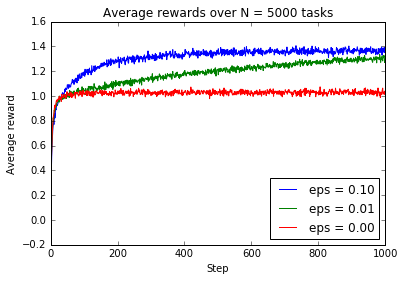

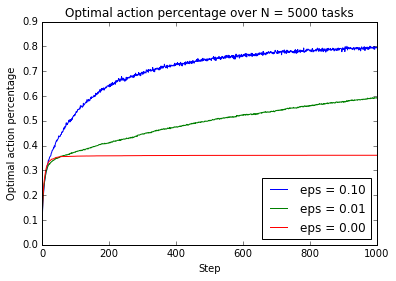

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

# Number of tasks to be run
N = 2000

# Run tasks for various epsilon values
r_0_1, o_0_1 = e_greed_experiment(e=0.1, N=N)
r_0_01, o_00_1 = e_greed_experiment(e=0.01, N=N)
r_0, o_0 = e_greed_experiment(e=0, N=N)

# Plot average rewards
plt.figure()
plt.plot(r_0_1, label="eps = 0.10")
plt.plot(r_0_01, label="eps = 0.01")
plt.plot(r_0, label="eps = 0.00")
plt.title("Average rewards over N = %d tasks" % N)
plt.xlabel("Step")
plt.ylabel("Average reward")
plt.legend(loc=4)
plt.show()

# Plot optimal action percentage
plt.figure()
plt.plot(o_0_1, label="eps = 0.10")
plt.plot(o_00_1, label="eps = 0.01")
plt.plot(o_0, label="eps = 0.00")
plt.title("Optimal action percentage over N = %d tasks" % N)
plt.xlabel("Step")
plt.ylabel("Optimal action percentage")
plt.legend(loc=4)
plt.show()

## Softmax Action Selection

In this method we fix a parameter called the temperature $\tau$ and select one action on step $t$ based on a Boltzmann distribution:

$$
P_t(a) = \frac{e^{\frac{Q_t(a)}{\tau}}}{\sum_{i=1}^{n}e^{\frac{Q_t(a)}{\tau}}}
$$

Below we have some experiments to test this method.

In [ ]:
def softmax_choice(Q, temperature=0.2):
    # Compute softmax probs
    probs = np.exp(Q/temperature)
    # Normalize probs
    probs = probs/probs.sum()
    # Sample an index with probs distribution
    return np.random.choice(range(len(probs)), p=probs)

def softmax_task(n=10, t=1000, temperature=0.2):
    """ Evaluate n-bandits task for t timesteps using softmax method.
    Returns: 
        R: reward vector with reward at each timestep 
        is_optimal: boolean vector cast as float for wheter the 
            optimal action was chosen at each timestep or not.  
    """
    
    # Initialize true action values from normal distribution
    q = np.random.normal(size=n)
    
    # Initialize estimated action values (mean reward) as zero 
    Q = np.zeros(n)
    
    # Historical action values as a matrix with bandits as rows
    r_history = [[] for i in range(n)]

    # Vector of rewards, one reward per timestep
    R = np.zeros(t)
    
    # Vector to keep record if the optimal action was performed
    is_optimal = np.zeros(t)

    # Optimal action is the one with the greatest true value
    optimal_action = np.argmax(q)

    # Main loop
    for step in range(t):
        # Deal with the exploration-exploitation dilemma using softmax
        i = softmax_choice(Q, temperature=temperature)
        
        # Update optimal choice vector
        is_optimal[step] = i == optimal_action
        
        # Step reward based on chosen bandit (i)
        r = q[i] + noise()
        
        # Set the current step reward
        R[step] = r
        
        # Append reward to historic vector for bandit i
        r_history[i].append(r)
        
        # Update estimated value for bandit i as the mean of it
        Q[i] = np.mean(r_history[i])
        
    return R, is_optimal

def softmax_experiment(N=100, n=10, t=1000, temperature=0.2):
    """ Perform N n-bandit tasks for t timesteps using softmax method.
    Returns: 
        mean_reward: mean reward vector with reward at each timestep 
        mean_optimal: float vector with percentage of optimal actions
            taken at each timestep.
    """
    mean_reward, mean_optimal = e_greed_task(n, t, temperature)
    for i in range(N-1):
        r, o = e_greed_task(n, t, temperature)
        mean_reward += r
        mean_optimal += o
    return mean_reward/N, mean_optimal/N

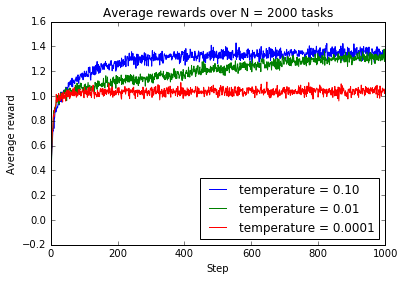

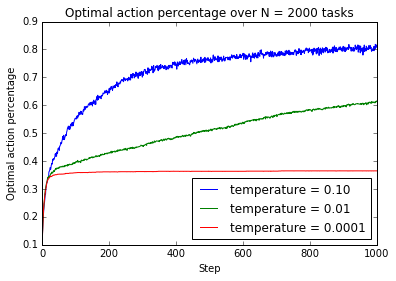

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

# Number of tasks to be run
N = 2000

# Run tasks for various epsilon values
r_0_1, o_0_1 = softmax_experiment(temperature=0.1, N=N)
r_0_01, o_0_01 = softmax_experiment(temperature=0.01, N=N)
r_0_0001, o_0_0001 = softmax_experiment(temperature=0.0001, N=N)

# Plot average rewards
plt.figure()
plt.plot(r_0_1, label="temperature = 0.10")
plt.plot(r_0_01, label="temperature = 0.01")
plt.plot(r_0_0001, label="temperature = 0.0001")
plt.title("Average rewards over N = %d tasks" % N)
plt.xlabel("Step")
plt.ylabel("Average reward")
plt.legend(loc=4)
plt.show()

# Plot optimal action percentage
plt.figure()
plt.plot(o_0_1, label="temperature = 0.10")
plt.plot(o_0_01, label="temperature = 0.01")
plt.plot(o_0_0001, label="temperature = 0.0001")
plt.title("Optimal action percentage over N = %d tasks" % N)
plt.xlabel("Step")
plt.ylabel("Optimal action percentage")
plt.legend(loc=4)
plt.show()

## Final remarks

We see from the above experiments that both methods can give similar results, each one having one parameter to be set. For an in-depth discussion of the advantages and drawbacks of each method we refer the reader to the great (and free!) book that inspired this code: [Reinforcement Learning: An Introduction](https://webdocs.cs.ualberta.ca/~sutton/book/the-book.html).